Identifiability (if model is allowed in only 1 direction)

The model is identifiable if:
- The cause-consequence relationship is **non-linear**.
- The cause-consequence relationship is **linear**, and **cause or noise are not normally distributed**. 

Attention: if cause-consequence relationship is linear; cause and noise are both normally distributed, then the model is not identifiable (we could not identifier the cause and consequence).

# Setting-up

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

## Function to test independence of 2 random variables

**Hilbert Schmidt Independence Criterion**

In [2]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
https://github.com/amber0309/HSIC
09/11/2016
Inputs:
X n by dim_x matrix
Y n by dim_y matrix
alph level of test
Outputs:
testStat test statistics
thresh test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape
    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)
    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))
    H = Q + R - 2* np.dot(pattern1, pattern2.T)
    H = np.exp(-H/2/(deg**2))
    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]
    # ----- width of X -----
    Xmed = X
    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    # ----- width of X -----
    Ymed = Y
    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n
    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)
    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)
    testStat = np.sum(Kc.T * Lc) / n
    varHSIC = (Kc * Lc / 6)**2
    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)
    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)
    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L)) 
    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)
    mHSIC = (1 + muX * muY - muX - muY) / n
    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC
    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]
    return (testStat, thresh)

# Structure Learning

The general idea is the following. We assume that we have a model with additive noise and that noise is independent of the cause: 
1. $Y=f(X) + \epsilon$
2. $X \perp \!\!\! \perp \epsilon$ 

If from our data we can see that the noise $\epsilon$ depends on the variable $X$ that we assume to be the cause, then we can reject this models. It means that $X$ cannot be a cause, because it does not satisfy the second condition. After that, we can proceed with testing another direction in a similar way: $X=f^{-1}(Y) + \epsilon$, $f^{-1}$ - inverse function.

For doing this, we will be checking independence between $X$ and the residuals of our predictive model. The latter corresponds to the noise term $\epsilon$.

We expect the model to be non-identifiable only in linear case and when $X$ and $\epsilon$ are normally distributed: $X,\epsilon \sim\ N(\mu, \sigma)$.

Below we are trying to reproduce the results from [Fig. 3](https://www.frontiersin.org/files/Articles/418407/fgene-10-00524-HTML/image_m/fgene-10-00524-g003.jpg) of the following paper [Glymour et al. - 2019 - Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full).

## Linear model $Y=bX+\epsilon$

### Data generation

Uncomment corresponding line to generate data according to the desired destribution

In [3]:
N = 1000
x = np.random.normal(0, 1, size=N)
# x = np.random.uniform(0, 1, size=N)
#x = np.random.laplace(loc=0.0, scale=1., size=N)
eps = np.random.normal(0, 1, size=N)
# eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)
y = x + eps

### Check model $Y:=f(X)+\epsilon$

Regress $Y$ on $X$

Text(0.5, 1.0, 'Residuals as a function of independent variable')

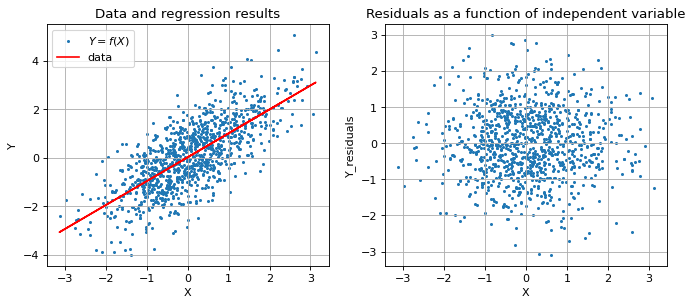

In [4]:
# build regression model
regressor = LinearRegression()
regressor.fit(x.reshape(-1, 1),y)
y_pred = regressor.predict(x.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y, s=3)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(['$Y=f(X)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals, s=3)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
plt.title('Residuals as a function of independent variable')

Testing independence

In [5]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.25900046967092144 0.5772953405089885
Independent: True


### Check model $X:=f(Y)+\epsilon$

Regress $X$ on $Y$

Text(0.5, 1.0, 'Residuals as a function of independent variable')

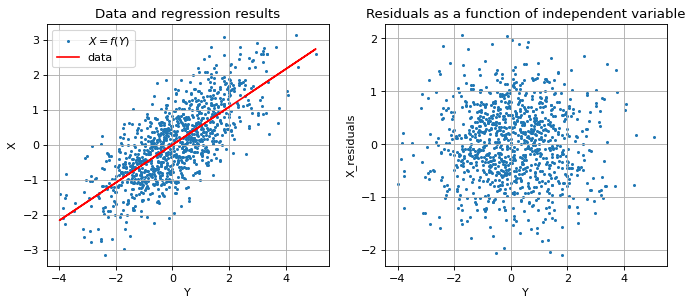

In [6]:
# build regression model
regressor.fit(y.reshape(-1, 1),x)
x_pred = regressor.predict(y.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x, s=3)
plt.plot(y, x_pred, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")
plt.legend(['$X=f(Y)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals, s=3)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
plt.title('Residuals as a function of independent variable')

Test independence

In [7]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.41862845555925216 0.5870787352767247
Independent: True


### Results

The results below are obtained for different combinations of distributions for $X$ and $\epsilon$. To see corresponding plots, uncomment corresponding lines in `Data generation`.


Independence results for $Y=f(X) + \epsilon$

| $\epsilon$ \ $X$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           |  $+$   |  $+$    |  $+$    |
| uniform          |  $+$   |  $+$    |  $+$    |
| laplace          |  $+$   |  $+$    |  $+$    |


Independence results for $X=f(Y) + \epsilon$

| $\epsilon$ \ $Y$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           | $+$    | $-$     | $-$     |
| uniform          | $-$    | $-$     | $-$     |
| laplace          | $-$    | $-$     | $-$     |

Identifiability (if model is allowed in only 1 direction)

| $\epsilon$ \ $X/Y$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           |   $-$  | $+$     | $+$     |
| uniform          |   $+$  | $+$     | $+$     |
| laplace          |   $+$  | $+$     | $+$     |

**As expected, we can identify cause in all cases, except the case when cause and noise are normally distributed: $X,\epsilon \sim\ N(\mu, \sigma)$.**

## Example of a non-linear model: $Y=bX^3+\epsilon$

### Data generation

In [8]:
N = 1000
x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
#x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = x**3 + eps

### Check model $Y:=f(X)+\epsilon$, in our case $Y:=X^3+\epsilon$

Regress $Y$ on $X$

Text(0.5, 1.0, 'Residuals as a function of independent variable')

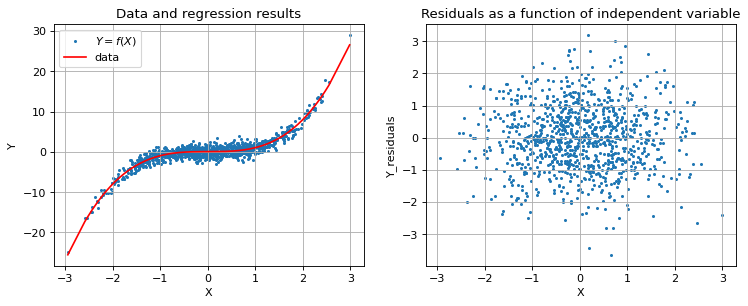

In [9]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = x**3
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y, s=3)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(['$Y=f(X)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals, s=3)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
plt.title('Residuals as a function of independent variable')

Testing independence

In [10]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.290283595769566 0.5836578771827858
Independent: True


### Check model $X:=f(Y)+\epsilon$, in our case $X:=\sqrt[3]{Y}+\epsilon$

Build regression model

Text(0.5, 1.0, 'Residuals as a function of independent variable')

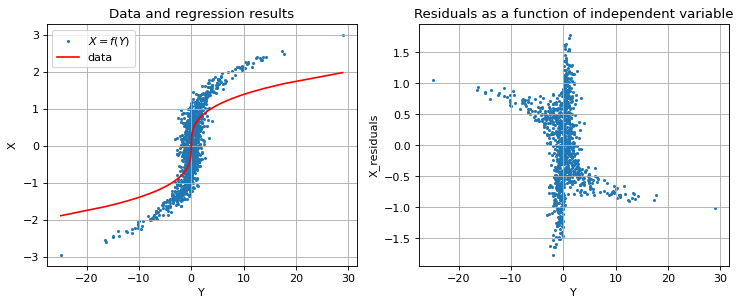

In [11]:
# build regression model
y_transform = np.cbrt(y)
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x, s=3)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")
plt.legend(['$X=f(Y)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals, s=3)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
plt.title('Residuals as a function of independent variable')

Why does the plot with regression look so strange? Let's look on plots in transformed coordinates: $X \rightarrow X$, $Y \rightarrow \sqrt[3]{Y}$

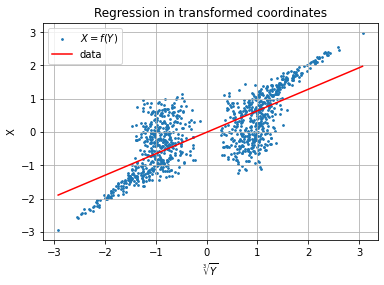

In [12]:
plt.scatter(y_transform, x, s=3)
plt.plot(y_transform, x_pred, color="red")
plt.xlabel("$\sqrt[3]{Y}$")
plt.ylabel("X")
plt.legend(['$X=f(Y)$', 'data'])
plt.title('Regression in transformed coordinates')
plt.grid(True)

Testing independence

In [13]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

6.3456740874737365 0.5641204318160619
Independent: False


### Results

The results below are obtained for different combinations of distributions for $X$ and $\epsilon$. To see the corresponding plots, uncomment corresponding lines in `Data generation`.


Independence results for $Y=f(X) + \epsilon$

| $\epsilon$ \ $X$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           |  $+$   |  $+$    |  $+$    |
| uniform          |  $+$   |  $+$    |  $+$    |
| laplace          |  $+$   |  $+$    |  $+$    |


Independence results for $X=f(Y) + \epsilon$

| $\epsilon$ \ $Y$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           | $-$    | $-$     | $-$     |
| uniform          | $-$    | $-$     | $-$     |
| laplace          | $-$    | $-$     | $-$     |

Identifiability (if model is allowed in only 1 direction)

| $\epsilon$ \ $X / Y$ | normal | uniform | laplace |
|------------------|--------|---------|---------|
| normal           |   $+$  | $+$     | $+$     |
| uniform          |   $+$  | $+$     | $+$     |
| laplace          |   $+$  | $+$     | $+$     |

Now we can identify cause in all cases!

# Be careful: Strength of noise matters!

In [ ]:
N = 1000
#x = np.random.uniform(0, 1, size=N)
x = np.random.uniform(0, 15, size=N)
eps = np.random.uniform(-0.5, 0.5, size=N)
y = x + eps

Regress $Y$ on $X$

Text(0.5, 1.0, 'Residuals as a function of independent variable')

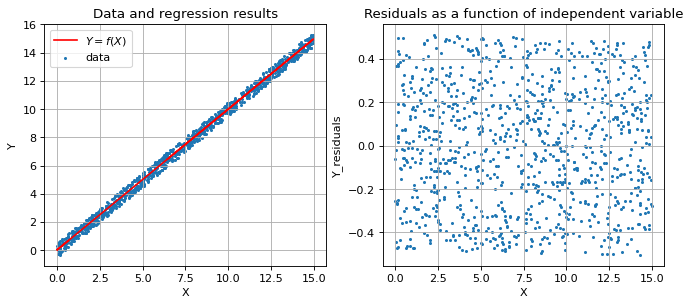

In [ ]:
# build regression model
regressor = LinearRegression()
regressor.fit(x.reshape(-1, 1),y)
y_pred = regressor.predict(x.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y, s=3)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(['$Y=f(X)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals, s=3)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
plt.title('Residuals as a function of independent variable')

In [ ]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.17249917371121506 0.6461420459720342
Independent: True


Regress $X$ on $Y$

Text(0.5, 1.0, 'Residuals as a function of independent variable')

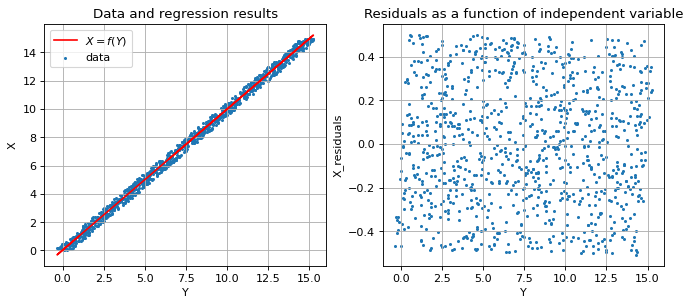

In [ ]:
# build regression model
regressor.fit(y.reshape(-1, 1),x)
x_pred = regressor.predict(y.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x, s=3)
plt.plot(y, x_pred, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")
plt.legend(['$X=f(Y)$', 'data'])
plt.title('Data and regression results')

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals, s=3)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
plt.title('Residuals as a function of independent variable')

In [ ]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.27577003492001356 0.6453255866435752
Independent: True
